In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done
import tensorflow as tf
import os
from data_processing import dataset
from models import model
from utils import tools
from plots import plots, edge_detection_plots

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#np.set_printoptions(threshold=sys.maxsize)

2022-12-16 09:53:18.495862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 09:53:18.796260: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-16 09:53:18.914513: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 09:53:20.211532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config_directory = 'edge_detection_without_prior'

config_path = os.path.join(os.getcwd(), 'configs', config_directory)
Model = model.Model(config_path)
DataProcessing = dataset.DataProcessing(input_shape_img=Model.cfg["INPUT_SHAPE_IMG"],
                                        output_shape=Model.cfg["OUTPUT_SHAPE"],
                                        config_path=config_path)
tools.parser(Model.cfg, DataProcessing.cfg)
Model.load_data(DataProcessing.cfg["NAME"])
DataProcessing.path_definitions()

2022-12-16 09:53:22.978170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 09:53:23.000476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 09:53:23.000675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-16 09:53:23.002111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

# Load Dataset, Preprocess Images and Dataset

In [3]:
if Model.train_model:
    train_ds, img_count_train = DataProcessing.load_dataset(DataProcessing.key.train)
test_ds, img_count_test = DataProcessing.load_dataset(DataProcessing.key.test)

img_only_ds, img_count_img_only_ds = DataProcessing.load_dataset(DataProcessing.key.img_only)

#if Model.train_model:
#    for inp, out in train_ds.take(1):
#        edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
#                                        batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
#                                        num_classes=DataProcessing.num_classes['edge'])

The TRAIN DS contains 869 images.
The TEST DS contains 109 images.
The IMG_ONLY DS contains 80 images.


# Define, Compile and Train Model

In [4]:
if Model.train_model:
    model = Model.get_neural_network_model(DataProcessing.num_classes['edge'])
    # model.summary()

    lr = Model.get_lr(img_count_train, DataProcessing.cfg['TRAIN']['BATCH_SIZE'])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss=Model.get_loss_function(),
                  metrics=Model.get_metrics(DataProcessing.num_classes['edge']))

    history = model.fit(train_ds, epochs=Model.cfg["EPOCHS"], validation_data=train_ds,
                        callbacks=Model.get_callbacks(), verbose=1)

model = Model.get_best_model_from_checkpoints()

(640, 360, 3)
Epoch 1/30


2022-12-16 09:53:49.675592: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-16 09:53:51.165896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


174/174 [==============================] - 42s 111ms/step - loss: 1177.5339 - out_edge_loss: 1177.5339 - accuracy: 0.8771 - accuracy_1: 0.8771 - f1: 0.2847 - precision: 0.2664 - recall: 0.3414 - f1_1: 0.2847 - precision_1: 0.2664 - recall_1: 0.3414 - val_loss: 1173.6829 - val_out_edge_loss: 1173.6829 - val_accuracy: 0.9460 - val_accuracy_1: 0.9460 - val_f1: 0.6080 - val_precision: 0.4980 - val_recall: 0.7805 - val_f1_1: 0.6080 - val_precision_1: 0.4980 - val_recall_1: 0.7805
Epoch 2/30
174/174 [==============================] - 26s 148ms/step - loss: 719.6948 - out_edge_loss: 719.6948 - accuracy: 0.9652 - accuracy_1: 0.9652 - f1: 0.6301 - precision: 0.7569 - recall: 0.5398 - f1_1: 0.6301 - precision_1: 0.7569 - recall_1: 0.5398 - val_loss: 773.8815 - val_out_edge_loss: 773.8815 - val_accuracy: 0.9657 - val_accuracy_1: 0.9657 - val_f1: 0.6963 - val_precision: 0.6623 - val_recall: 0.7341 - val_f1_1: 0.6963 - val_precision_1: 0.6623 - val_recall_1: 0.7341
Epoch 3/30
174/174 [=============

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=521.37-epoch=10.00-f1=0.7490/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=521.37-epoch=10.00-f1=0.7490/assets


174/174 [==============================] - 32s 181ms/step - loss: 551.3898 - out_edge_loss: 551.3898 - accuracy: 0.9736 - accuracy_1: 0.9736 - f1: 0.7325 - precision: 0.8167 - recall: 0.6644 - f1_1: 0.7325 - precision_1: 0.8167 - recall_1: 0.6644 - val_loss: 521.3663 - val_out_edge_loss: 521.3663 - val_accuracy: 0.9754 - val_accuracy_1: 0.9754 - val_f1: 0.7490 - val_precision: 0.8275 - val_recall: 0.6842 - val_f1_1: 0.7490 - val_precision_1: 0.8275 - val_recall_1: 0.6842
Epoch 11/30
174/174 [==============================] - 29s 170ms/step - loss: 544.4124 - out_edge_loss: 544.4124 - accuracy: 0.9735 - accuracy_1: 0.9735 - f1: 0.7312 - precision: 0.8137 - recall: 0.6641 - f1_1: 0.7312 - precision_1: 0.8137 - recall_1: 0.6641 - val_loss: 586.7246 - val_out_edge_loss: 586.7246 - val_accuracy: 0.9726 - val_accuracy_1: 0.9726 - val_f1: 0.7415 - val_precision: 0.7508 - val_recall: 0.7324 - val_f1_1: 0.7415 - val_precision_1: 0.7508 - val_recall_1: 0.7324
Epoch 12/30
174/174 [===============

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=451.68-epoch=20.00-f1=0.7769/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=451.68-epoch=20.00-f1=0.7769/assets


174/174 [==============================] - 38s 220ms/step - loss: 469.8094 - out_edge_loss: 469.8094 - accuracy: 0.9778 - accuracy_1: 0.9778 - f1: 0.7812 - precision: 0.8346 - recall: 0.7343 - f1_1: 0.7812 - precision_1: 0.8346 - recall_1: 0.7343 - val_loss: 451.6794 - val_out_edge_loss: 451.6794 - val_accuracy: 0.9783 - val_accuracy_1: 0.9783 - val_f1: 0.7769 - val_precision: 0.8650 - val_recall: 0.7051 - val_f1_1: 0.7769 - val_precision_1: 0.8650 - val_recall_1: 0.7051
Epoch 21/30
174/174 [==============================] - 22s 125ms/step - loss: 472.5437 - out_edge_loss: 472.5437 - accuracy: 0.9779 - accuracy_1: 0.9779 - f1: 0.7820 - precision: 0.8377 - recall: 0.7333 - f1_1: 0.7820 - precision_1: 0.8377 - recall_1: 0.7333 - val_loss: 487.2574 - val_out_edge_loss: 487.2574 - val_accuracy: 0.9760 - val_accuracy_1: 0.9760 - val_f1: 0.7858 - val_precision: 0.7547 - val_recall: 0.8196 - val_f1_1: 0.7858 - val_precision_1: 0.7547 - val_recall_1: 0.8196
Epoch 22/30
174/174 [===============

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=415.19-epoch=30.00-f1=0.7978/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=415.19-epoch=30.00-f1=0.7978/assets


174/174 [==============================] - 33s 192ms/step - loss: 420.8481 - out_edge_loss: 420.8481 - accuracy: 0.9802 - accuracy_1: 0.9802 - f1: 0.8084 - precision: 0.8533 - recall: 0.7680 - f1_1: 0.8084 - precision_1: 0.8533 - recall_1: 0.7680 - val_loss: 415.1867 - val_out_edge_loss: 415.1867 - val_accuracy: 0.9800 - val_accuracy_1: 0.9800 - val_f1: 0.7978 - val_precision: 0.8723 - val_recall: 0.7351 - val_f1_1: 0.7978 - val_precision_1: 0.8723 - val_recall_1: 0.7351
/home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/CKPT/ckpt-loss=415.19-epoch=30.00-f1=0.7978


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE/assets


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_img (InputLayer)            [(None, 640, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 base_model (Functional)        [(None, 320, 180, 8  4096        ['in_img[0][0]']                 
                                ),                                                                
                                 (None, 160, 90, 8)                                               
                                ]                                                                 
                                                                                              

 pyramid_1_bn (BatchNormalizati  (None, 80, 45, 3)   12          ['pyramid_1_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 pyramid_2_bn (BatchNormalizati  (None, 80, 45, 3)   12          ['pyramid_2_conv[0][0]']         
 on)                                                                                              
                                                                                                  
 pyramid_3_bn (BatchNormalizati  (None, 80, 45, 2)   8           ['pyramid_3_separable_conv[0][0]'
 on)                                                             ]                                
                                                                                                  
 pyramid_4_bn (BatchNormalizati  (None, 80, 45, 1)   4           ['pyramid_4_separable_conv[0][0]'
 on)      

 side_4_conv3x3_relu (ReLU)     (None, 320, 180, 2)  0           ['side_4_conv3x3_bn[0][0]']      
                                                                                                  
 side_5_conv3x3_relu (ReLU)     (None, 320, 180, 2)  0           ['side_5_conv3x3_bn[0][0]']      
                                                                                                  
 decoder_1_bn (BatchNormalizati  (None, 320, 180, 5)  20         ['decoder_1_separable_conv[0][0]'
 on)                                                             ]                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 320, 180, 4)  0           ['side_4_conv3x3_relu[0][0]',    
                                                                  'side_5_conv3x3_relu[0][0]']    
                                                                                                  
 decoder_1

 ization)                                                                                         
                                                                                                  
 out_concat_1_0_relu (ReLU)     (None, 320, 180, 5)  0           ['out_concat_1_0_bn[0][0]']      
                                                                                                  
 out_concat_2_0_conv (Conv2D)   (None, 320, 180, 5)  30          ['out_concat_1_0_relu[0][0]']    
                                                                                                  
 out_concat_2_0_bn (BatchNormal  (None, 320, 180, 5)  20         ['out_concat_2_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 out_concat_2_0_relu (ReLU)     (None, 320, 180, 5)  0           ['out_concat_2_0_bn[0][0]']      
          

# Plot Results

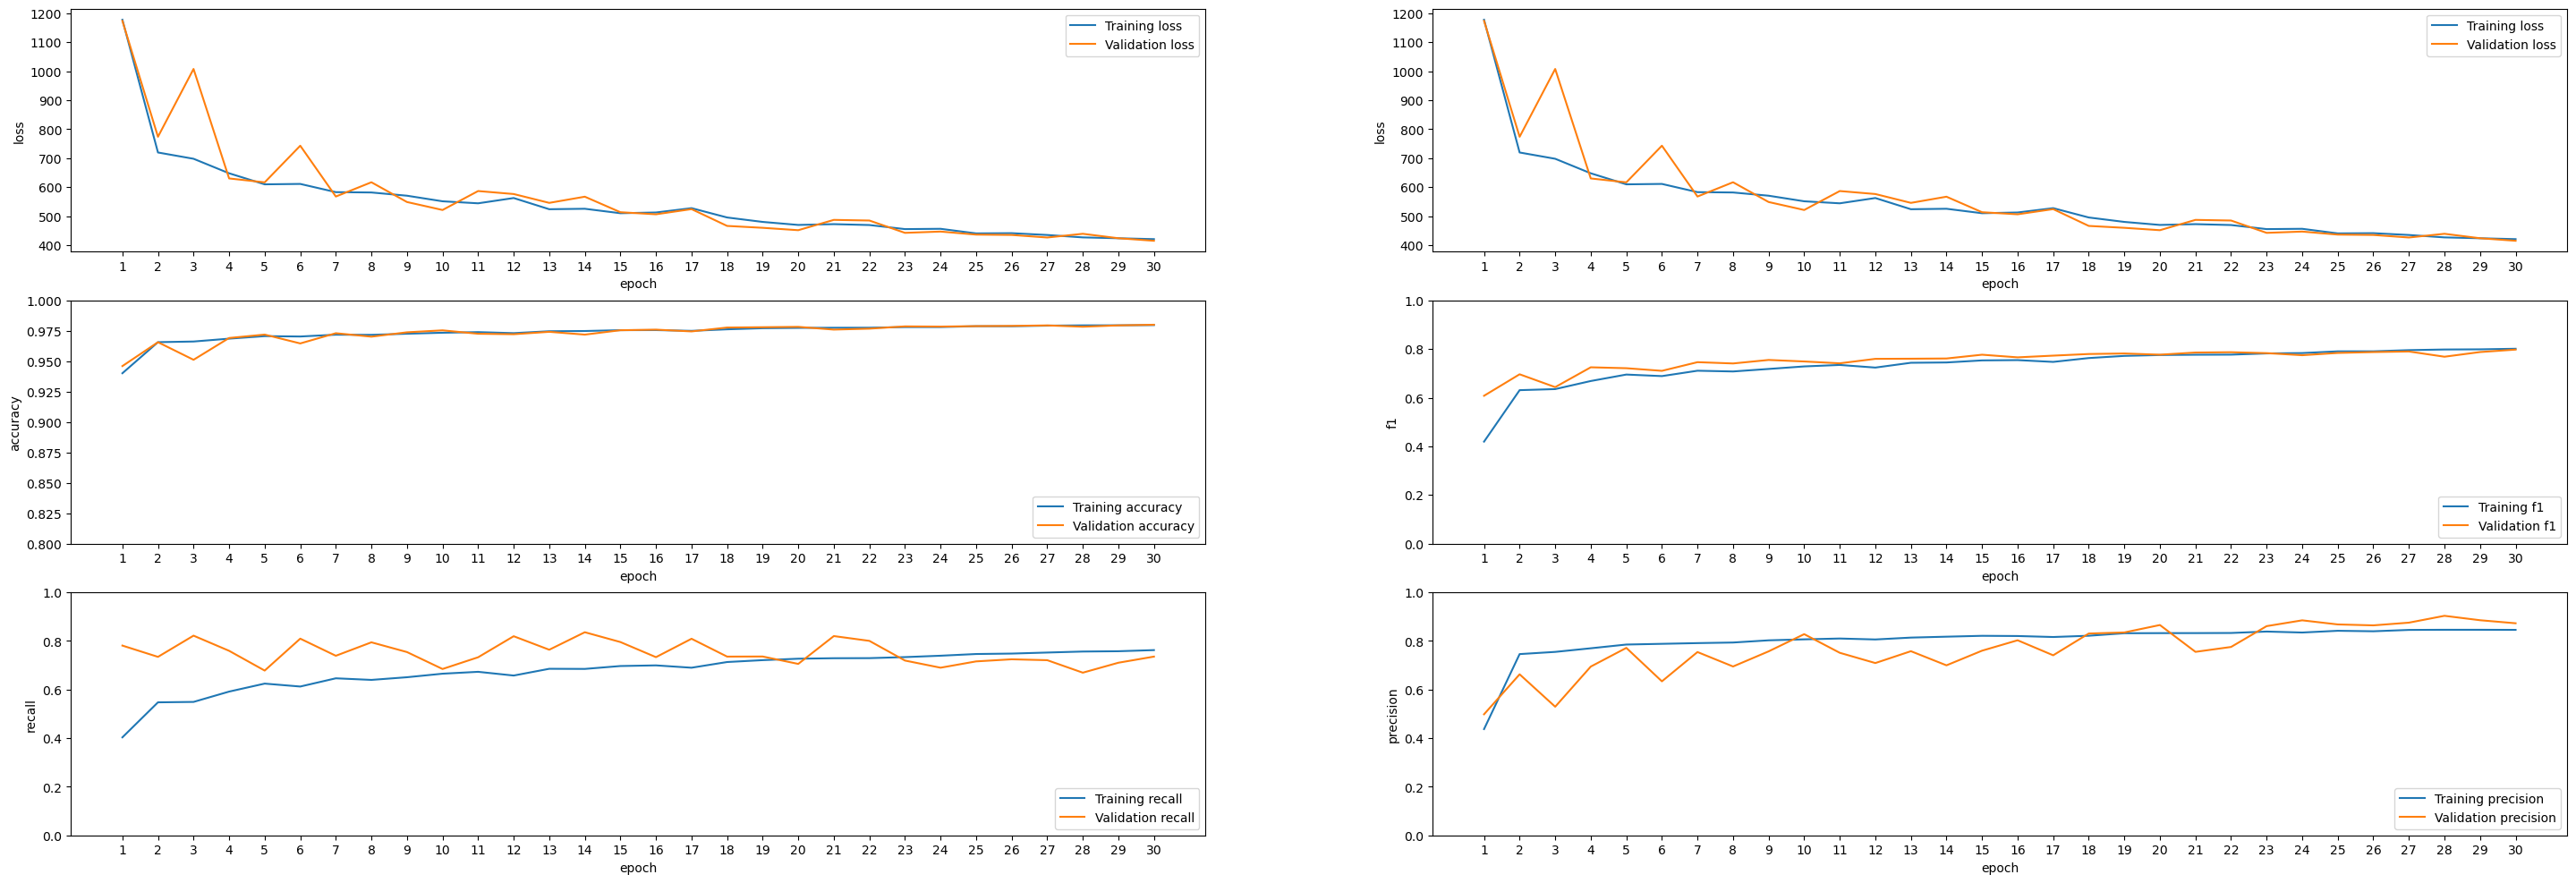

In [6]:
if Model.train_model:
    plot_losses = ["loss", "loss"]
    plot_metrics = ["accuracy", "f1", "recall", "precision"]

    path = os.path.join(Model.Data.paths["FIGURES"], "training.svg")

    plots.plot_training_history(history=history.history, list_of_loss_names=plot_losses,
                                list_of_metric_names=plot_metrics,
                                save=Model.cfg["SAVE"], path=path)

1/1 [==============================] - 1s 1s/step


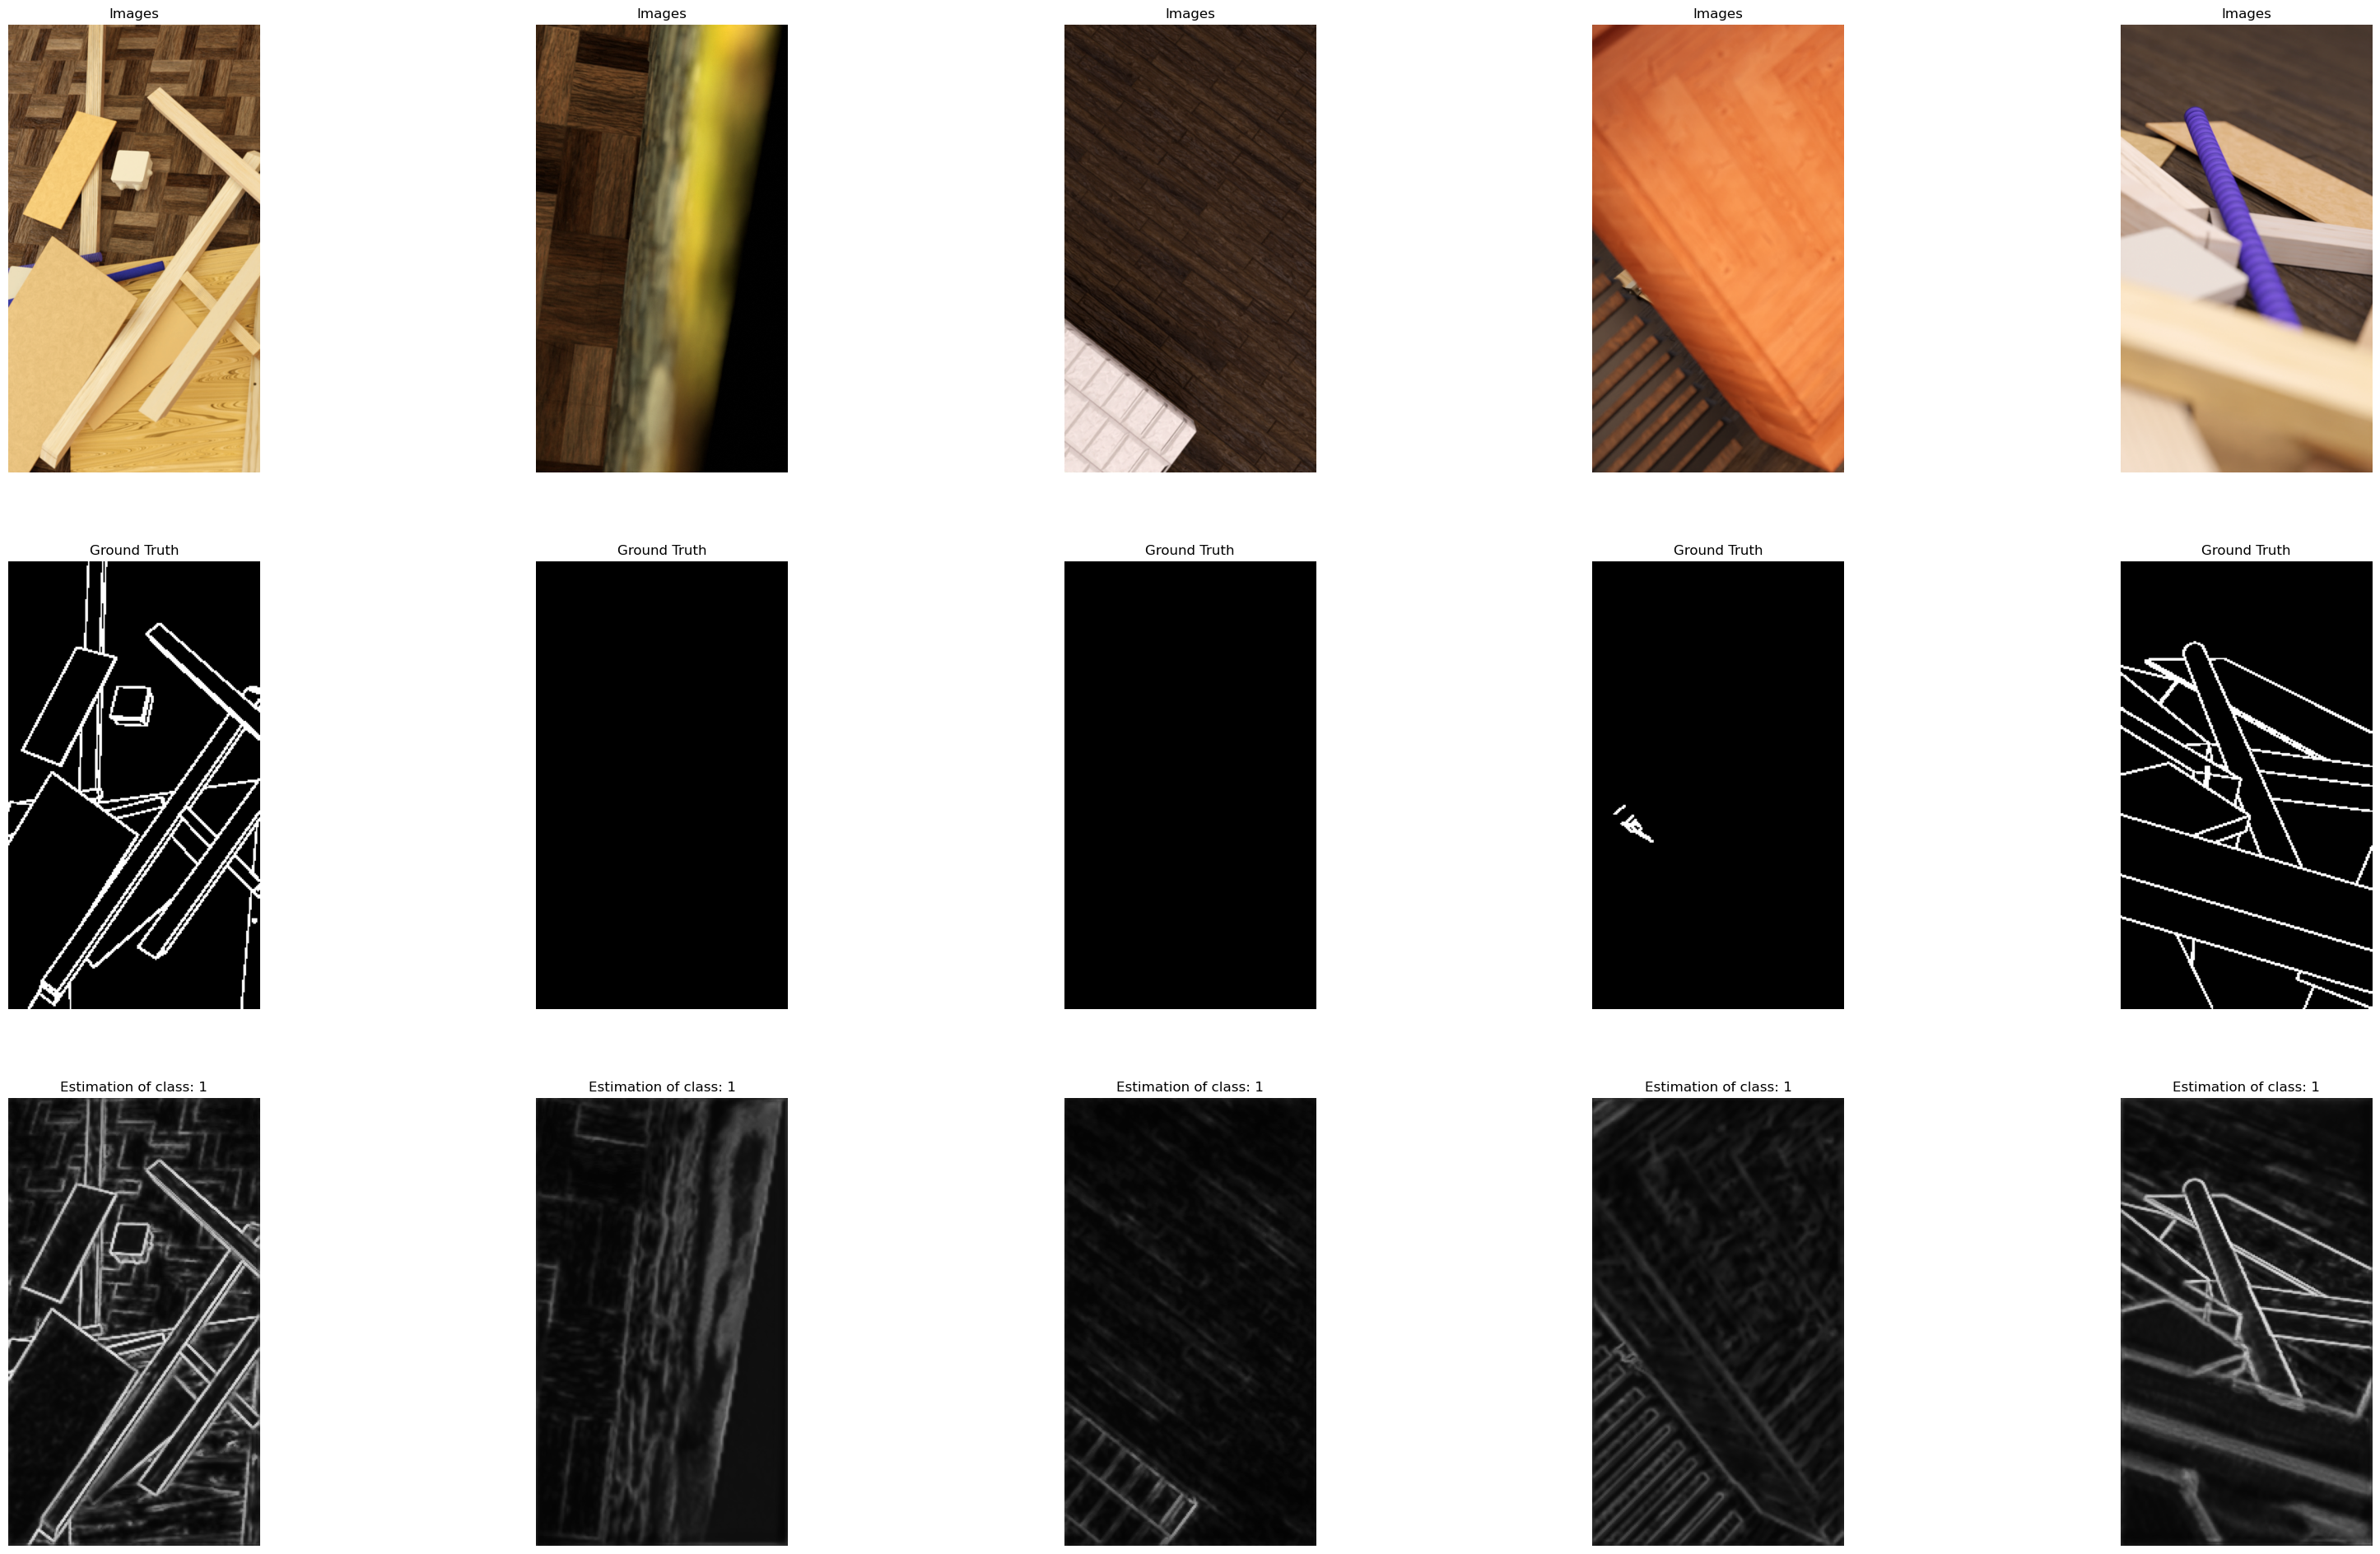

2022-12-16 10:10:35.154460: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [7]:
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    edge_detection_plots.plot_edges(images=inp['in_img'], labels=out['out_edge'],
                                    predictions=pred[0],
                                    batch_size=DataProcessing.cfg['TEST']['BATCH_SIZE'],
                                    num_classes=DataProcessing.num_classes['edge'])

1/1 [==============================] - 0s 109ms/step


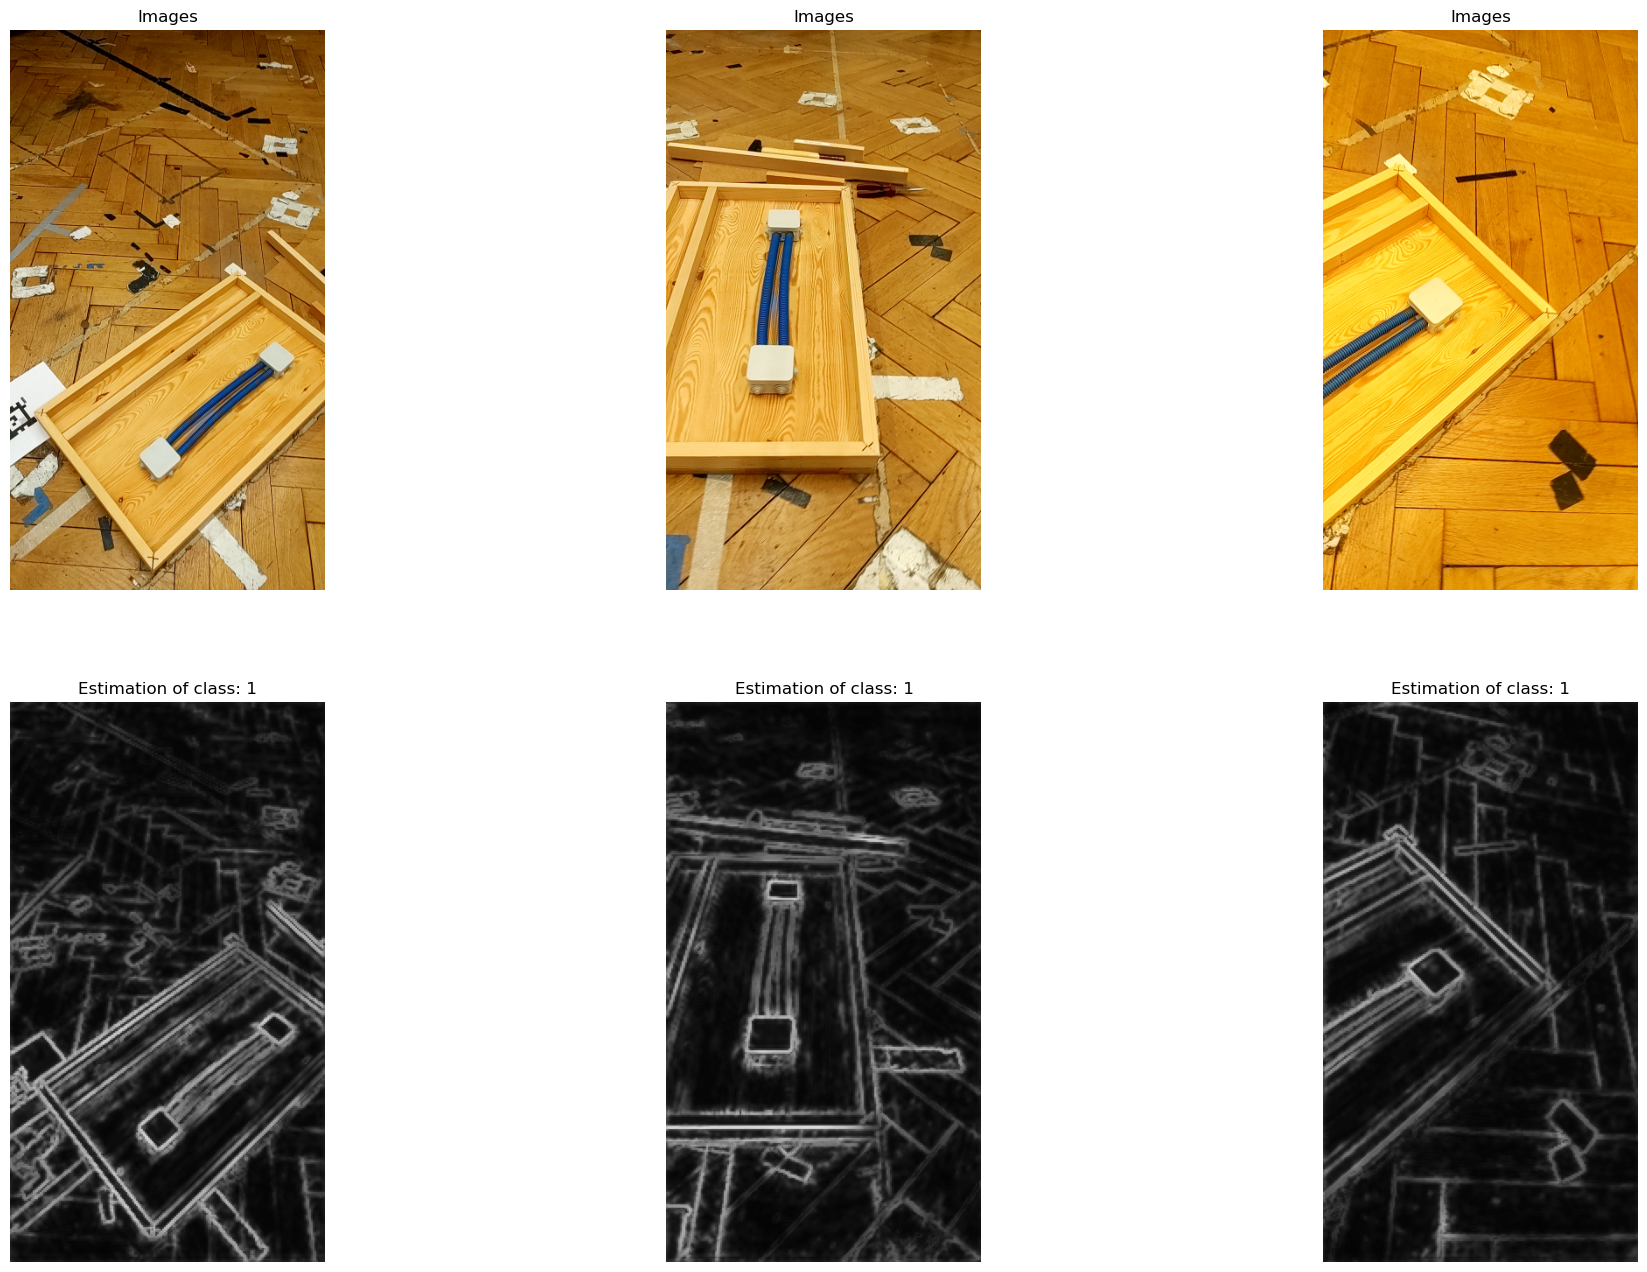

2022-12-16 10:10:37.146548: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
for inp, out in img_only_ds.take(1):
    pred = model.predict(inp)
    edge_detection_plots.plot_edges(images=inp['in_img'],
                                    predictions=pred[0],
                                    batch_size=DataProcessing.cfg['IMG_ONLY']['BATCH_SIZE'],
                                    num_classes=DataProcessing.num_classes['edge'])

1/1 [==============================] - 0s 77ms/step


2022-12-16 10:10:37.666579: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


IndexError: index 2 is out of bounds for axis 3 with size 2

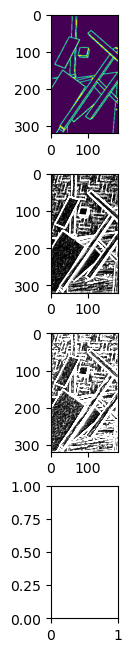

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,10))

output = 1 # pyramid_out
num = 4
batch = 5
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    out_pred = pred[output]
    for i in range(batch):
        plt.subplot(num+1, batch, i + 1)
        plt.imshow((out["out_edge"][i,:,:,0]))
        for j in range(num):
            plt.subplot(num+1, batch, batch*(1+j) + i + 1)
            plt.imshow(out_pred[i,:,:,j], cmap='gray', vmin=0, vmax=1)
plt.show()

1/1 [==============================] - 2s 2s/step


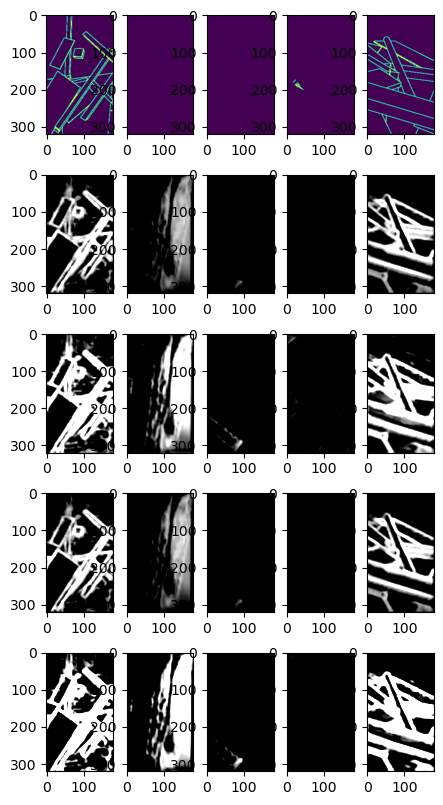

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,10))

output = 2 # image_layer
num = 4
batch = 5
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    out_pred = pred[output]
    for i in range(batch):
        plt.subplot(num+1, batch, i + 1)
        plt.imshow((out["out_edge"][i,:,:,0]))
        for j in range(num):
            plt.subplot(num+1, batch, batch*(1+j) + i + 1)
            plt.imshow(out_pred[i,:,:,j], cmap='gray', vmin=0, vmax=1)
plt.show()

1/1 [==============================] - 0s 42ms/step


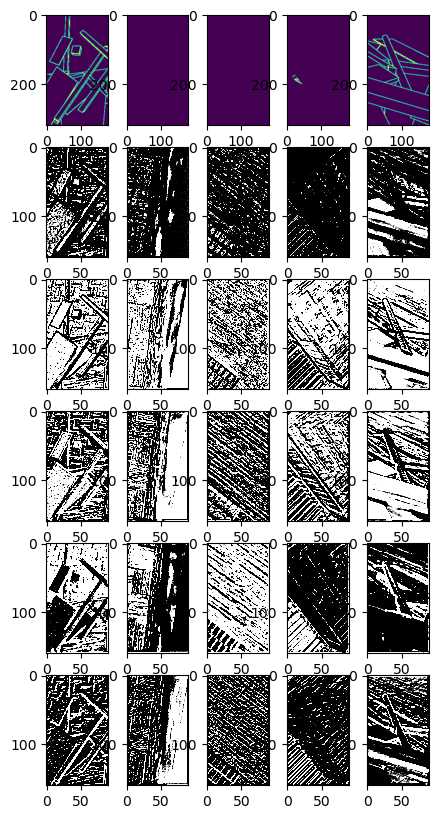

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,10))

output = 3 # decoder
num = 5
batch = 5
for inp, out in test_ds.take(1):
    pred = model.predict(inp)
    out_pred = pred[output]
    for i in range(batch):
        plt.subplot(num+1, batch, i + 1)
        plt.imshow((out["out_edge"][i,:,:,0]))
        for j in range(num):
            plt.subplot(num+1, batch, batch*(1+j) + i + 1)
            plt.imshow(out_pred[i,:,:,j], cmap='gray', vmin=0, vmax=1)
plt.show()

Max Accuracy Score = 0.976 at 0.500
MF1 = 0.758
MF1_1 = 0.758, ODS_1 = 0.500


[0.5]

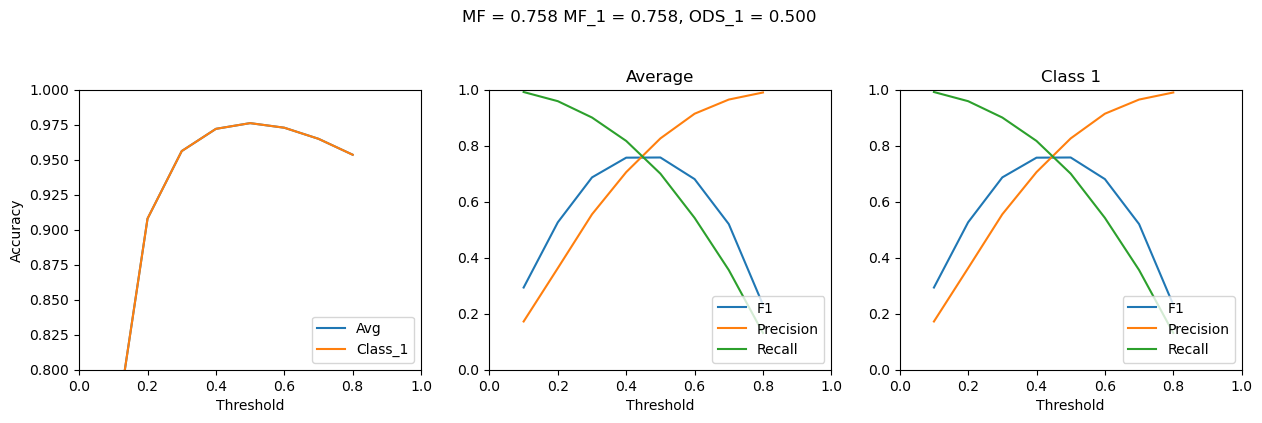

In [13]:
### Maximum F1 Score:
path_metrics_evaluation_plot = os.path.join(Model.Data.paths["FIGURES"],
                                            "threshold_metrics_evaluation_test_ds.svg")

edge_detection_plots.plot_threshold_metrics_evaluation(model=model, ds=test_ds,
                                                       num_classes=DataProcessing.num_classes['edge'],
                                                       classes_displayed_individually=True,
                                                       save=Model.cfg["SAVE"],
                                                       path=path_metrics_evaluation_plot,
                                                       accuracy_y_lim_min=0.8)


In [14]:
if Model.cfg["CONVERT_TO_TFLITE"]:
    Model.convert_model_to_tflite(model)

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE/assets


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE/assets
2022-12-16 10:11:54.023447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-16 10:11:54.023507: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-16 10:11:54.024815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE
2022-12-16 10:11:54.073428: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-16 10:11:54.073499: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /home/david/SemesterProject/Models/edge_detection/edge_detection_without_prior/TFLITE
2022-12-16 10:11:54.173265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass 

=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the DEQUANTIZE op takes
tensor #10 as input and produces tensor #97 as output.

Subgraph#0 main(T#0) -> [T#205, T#251, T#237, T#194]
  Op#0 DEQUANTIZE(T#10[]) -> [T#97]
  Op#1 DEQUANTIZE(T#11[]) -> [T#98]
  Op#2 DEQUANTIZE(T#12[]) -> [T#99]
  Op#3 DEQUANTIZE(T#13[]) -> [T#100]
  Op#4 DEQUANTIZE(T#14[]) -> [T#101]
  Op#5 DEQUANTIZE(T#15[]) -> [T#102]
  Op#6 DEQUANTIZE(T#16[]) -> [T#103]
  Op#7 DEQUANTIZE(T#17[]) -> [T#104]
  Op#8 DEQUANTIZE(T#18[]) -> [T#105]
  Op#9 DEQUANTIZE(T#19[]) -> [T#106]
  Op#10 DEQUANTIZE(T#20[]) -> [T#107]
  Op#11 DEQUANTIZE(T#21[]) -> [T#108]
  Op#12 DEQUANTIZE(T#22[]) -> [T#109]
  Op#13 DEQUANTIZE(T#23[]) -> [T#110]
  Op#14 DEQUANTIZE(T#24[]) -> [T#111]
  Op#15 DEQUANTIZE(T#25[]) -> [T#112]
  Op#16 DEQUANTIZE(T#26[]) -> [T#113]
  Op#17 DEQUANTIZE(T#27[]) -> [T#114]
  Op#18 DEQUANTIZE(T#28[]) -> 